# Data E-Coli

## Bussiness Understanding

Tujuan :
1. Memahami Data: Melakukan analisis eksplorasi untuk memahami karakteristik setiap fitur dan distribusi kelas target.
2. Preprocessing & Visualisasi Awal: Menyiapkan data dan memvisualisasikan data asli menggunakan PCA (Principal Component Analysis) untuk melihat bagaimana kelas-kelas terpisah dalam ruang 2 dimensi.
3. Penyeimbangan Data: Mengatasi masalah ketidakseimbangan kelas menggunakan teknik oversampling ADASYN (Adaptive Synthetic Sampling) untuk menghasilkan data sintetis bagi kelas minoritas.
4. Visualisasi Akhir: Memvisualisasikan kembali data yang telah diseimbangkan menggunakan PCA untuk membandingkan distribusinya dengan data asli dan menyorot data baru yang dihasilkan.

(Langkah Selanjutnya) Setelah data seimbang, langkah berikutnya adalah melatih dan mengevaluasi beberapa model klasifikasi untuk menemukan yang terbaik.

## Data Understanding

Sumber Data :
Dataset Ecoli ini berasal dari UCI Machine Learning Repository dan dikelola oleh Kenta Nakai. Dataset ini berisi 336 sampel protein E. coli.

Deskripsi Atribut :
Dataset memiliki 8 atribut, yang terdiri dari 1 nama sekuens (sebagai identifier) dan 7 atribut prediktif (fitur).
| Nama Atribut | Tipe Data | Deskripsi |
| :--- | :--- | :--- |
| **Sequence Name** | Teks | [cite_start]Nomor akses untuk database SWISS-PROT[cite: 67]. |
| **mcg** | Numerik | [cite_start]Skor metode McGeoch untuk pengenalan sinyal sekuens[cite: 67]. |
| **gvh** | Numerik | [cite_start]Skor metode von Heijne untuk pengenalan sinyal sekuens[cite: 68]. |
| **lip** | Kategorikal (Biner) | [cite_start]Skor konsensus sinyal Peptidase II von Heijne[cite: 69]. |
| **chg** | Kategorikal (Biner) | [cite_start]Kehadiran muatan pada N-terminus dari lipoprotein yang diprediksi[cite: 70]. |
| **aac** | Numerik | [cite_start]Skor analisis diskriminan dari kandungan asam amino[cite: 71]. |
| **alm1** | Numerik | [cite_start]Skor dari program prediksi ALOM untuk region transmembran[cite: 72]. |
| **alm2** | Numerik | [cite_start]Skor program ALOM setelah mengecualikan sinyal sekuens[cite: 73]. |
| **Localization Site**| Kategorikal | [cite_start]Lokasi protein di dalam sel (kelas target)[cite: 63]. |

Distribusi Kelas :
Distribusi kelas target menunjukkan ketidakseimbangan yang signifikan. Ini adalah justifikasi utama mengapa penyeimbangan data diperlukan.
- cp (cytoplasm): 143 
- im (inner membrane without signal sequence): 77 
- pp (periplasm): 52 
- imU (inner membrane, uncleavable signal sequence): 35 
- om (outer membrane): 20 
- omL (outer membrane lipoprotein): 5 
- imL (inner membrane lipoprotein): 2 
- imS (inner membrane, cleavable signal sequence): 2 

## Data Preparation & Modelling

Pada tahap ini, kita akan membersihkan, menyeimbangkan dan mentransformasi data agar siap digunakan untuk pemodelan. Langkah utamanya adalah menangani masalah data tidak seimbang (imbalanced data) yang telah kita identifikasi sebelumnya.

Memuat data

In [84]:
import pandas as pd
import mysql.connector

conn = mysql.connector.connect(
  host='127.0.0.1',
  user='root',
  password='',
  database='psd'
)

df = pd.read_sql("SELECT * FROM ecoli", conn)
print("\nIsi tabel ecoli:")
print(df)


Isi tabel ecoli:
      id protein_name   mcg   gvh   lip  chg   aac  alm1  alm2  \
0      1    AAT_ECOLI  0.49  0.29  0.48  0.5  0.56  0.24  0.35   
1      2   ACEA_ECOLI  0.07  0.40  0.48  0.5  0.54  0.35  0.44   
2      3   ACEK_ECOLI  0.56  0.40  0.48  0.5  0.49  0.37  0.46   
3      4   ACKA_ECOLI  0.59  0.49  0.48  0.5  0.52  0.45  0.36   
4      5    ADI_ECOLI  0.23  0.32  0.48  0.5  0.55  0.25  0.35   
..   ...          ...   ...   ...   ...  ...   ...   ...   ...   
331  332   TREA_ECOLI  0.74  0.56  0.48  0.5  0.47  0.68  0.30   
332  333   UGPB_ECOLI  0.71  0.57  0.48  0.5  0.48  0.35  0.32   
333  334   USHA_ECOLI  0.61  0.60  0.48  0.5  0.44  0.39  0.38   
334  335   XYLF_ECOLI  0.59  0.61  0.48  0.5  0.42  0.42  0.37   
335  336   YTFQ_ECOLI  0.74  0.74  0.48  0.5  0.31  0.53  0.52   

    localization_class  
0                   cp  
1                   cp  
2                   cp  
3                   cp  
4                   cp  
..                 ...  
331           

C:\Users\user\AppData\Local\Temp\ipykernel_24140\1178689391.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("SELECT * FROM ecoli", conn)


In [85]:
species_counts = df['localization_class'].value_counts()
print("Jumlah pada tiap kelas di kolom localization_class:")
print(species_counts)

Jumlah pada tiap kelas di kolom localization_class:
localization_class
cp     143
im      77
pp      52
imU     35
om      20
omL      5
imS      2
imL      2
Name: count, dtype: int64


Visualisasi Data menggunakan PCA LDA

In [86]:
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable


explained variance ratio (first two components): [0.5161681 0.2442034]


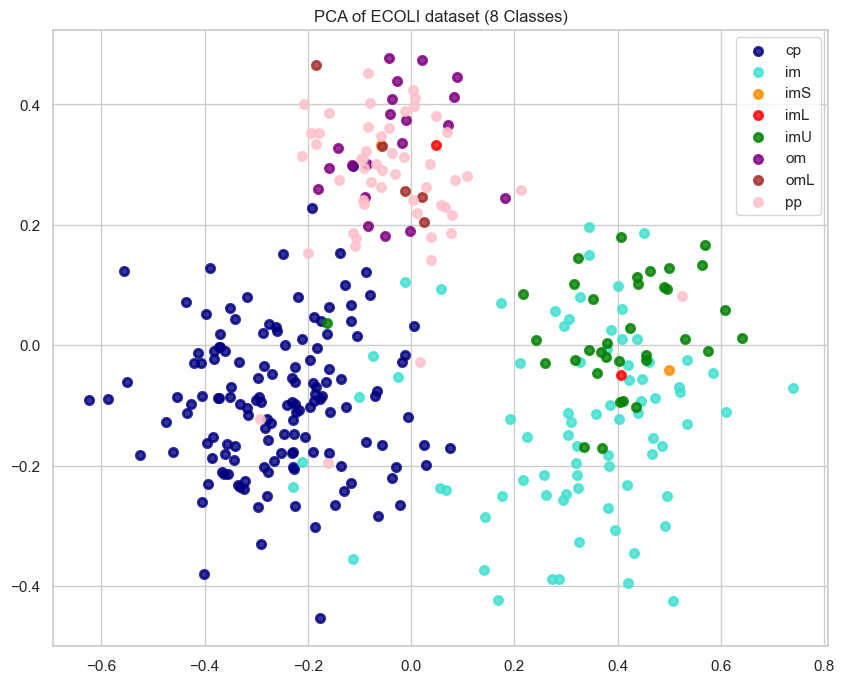

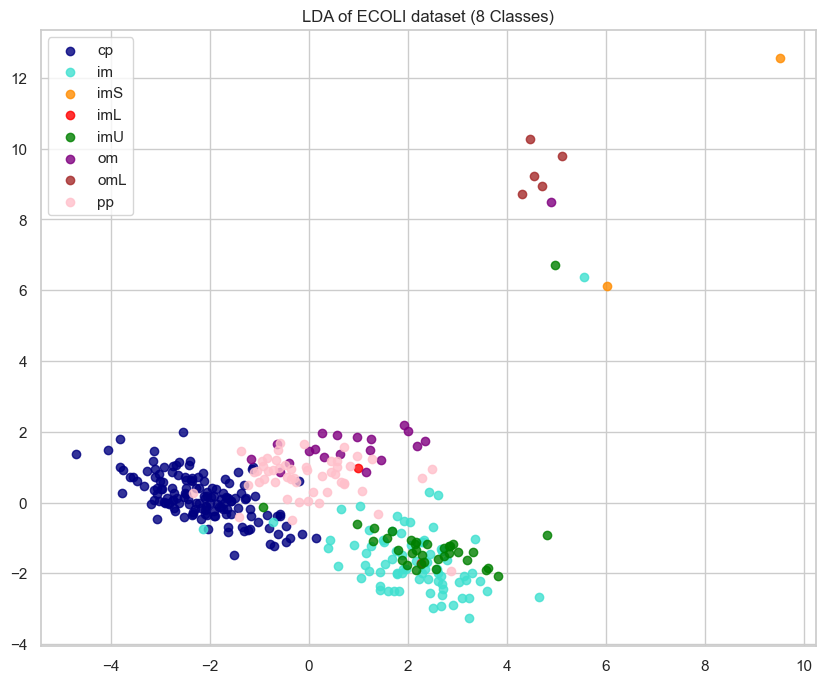

In [87]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


# --- Persiapan Data (Sama seperti sebelumnya) ---
X = df.drop(columns=["id", "protein_name", "localization_class"]).values
y = df["localization_class"].astype("category").cat.codes.values
target_names = df["localization_class"].unique()

# --- Model PCA dan LDA (Sama seperti sebelumnya) ---
pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(X, y).transform(X)

print(
    "explained variance ratio (first two components): %s"
    % str(pca.explained_variance_ratio_)
)

# --- Visualisasi PCA (Diperbaiki) ---
plt.figure(figsize=(10, 8))
# Menyiapkan 8 warna untuk 8 kelas
colors = ['navy', 'turquoise', 'darkorange', 'red', 'green', 'purple', 'brown', 'pink']
lw = 2

# Loop melalui semua kelas (bukan hanya 3)
for color, i, target_name in zip(colors, range(len(target_names)), target_names):
    plt.scatter(
        X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=0.8, lw=lw, label=target_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA of ECOLI dataset (8 Classes)")
plt.grid(True)

# --- Visualisasi LDA (Diperbaiki) ---
plt.figure(figsize=(10, 8))
# Menggunakan warna yang sama untuk konsistensi
for color, i, target_name in zip(colors, range(len(target_names)), target_names):
    plt.scatter(
        X_r2[y == i, 0], X_r2[y == i, 1], alpha=0.8, color=color, label=target_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("LDA of ECOLI dataset (8 Classes)")
plt.grid(True)

plt.show()

Klasifikasi sebelum data diseimbangkan

Naive Bayes

Pada tahap ini, kita menggunakan Naive Bayes (GaussianNB) untuk melakukan klasifikasi pada dataset asli sebelum diseimbangkan

Langkah-langkah:

- Pisahkan data menjadi training dan testing (80:20, stratified).
- Latih model Naive Bayes pada data training.
- Evaluasi model dengan data testing menggunakan akurasi, classification report, dan confusion matrix.

In [88]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Pisahkan data (belum seimbang)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Inisialisasi model Naive Bayes
nb = GaussianNB()

# Latih model
nb.fit(X_train, y_train)

# Prediksi data uji
y_pred = nb.predict(X_test)

# Evaluasi hasil
print("Akurasi Naive Bayes (data asli):", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Akurasi Naive Bayes (data asli): 0.7941176470588235

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98        29
           1       1.00      0.44      0.61        16
           4       0.50      0.86      0.63         7
           5       0.00      0.00      0.00         4
           6       1.00      1.00      1.00         1
           7       0.61      1.00      0.76        11

    accuracy                           0.79        68
   macro avg       0.68      0.72      0.66        68
weighted avg       0.81      0.79      0.76        68


Confusion Matrix:
 [[29  0  0  0  0  0]
 [ 1  7  6  0  0  2]
 [ 0  0  6  0  0  1]
 [ 0  0  0  0  0  4]
 [ 0  0  0  0  1  0]
 [ 0  0  0  0  0 11]]


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

Random Forest

Pada tahap ini, kita menggunakan Random Forest Classifier untuk melakukan klasifikasi pada dataset asli tanpa penyeimbangan kelas.
Langkah-langkah:

Pisahkan data menjadi training dan testing (80:20, stratified).
Latih model Random Forest pada data training.
Evaluasi model dengan data testing menggunakan akurasi, classification report, dan confusion matrix.

In [89]:
from sklearn.ensemble import RandomForestClassifier

# Pisahkan data (belum seimbang)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Inisialisasi Random Forest
rf = RandomForestClassifier(
    n_estimators=100,      # jumlah pohon
    random_state=42,
    class_weight=None      # karena data belum seimbang, kita biarkan default
)

# Latih model
rf.fit(X_train, y_train)

# Prediksi data uji
y_pred = rf.predict(X_test)

# Evaluasi hasil
print("Akurasi Random Forest (data asli):", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Akurasi Random Forest (data asli): 0.8676470588235294

Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97        29
           1       0.91      0.62      0.74        16
           4       0.50      0.86      0.63         7
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         1
           7       1.00      0.82      0.90        11

    accuracy                           0.87        68
   macro avg       0.89      0.88      0.87        68
weighted avg       0.90      0.87      0.87        68


Confusion Matrix:
 [[29  0  0  0  0  0]
 [ 0 10  6  0  0  0]
 [ 0  1  6  0  0  0]
 [ 0  0  0  4  0  0]
 [ 0  0  0  0  1  0]
 [ 2  0  0  0  0  9]]


Bagging Classifier

Pada tahap ini, kita menggunakan Bagging Classifier untuk melakukan klasifikasi pada dataset asli tanpa penyeimbangan kelas.
Bagging akan dilatih dengan dua skenario:
1. Menggunakan Naive Bayes sebagai base estimator.
2. Menggunakan Decision Tree sebagai base estimator (default yang paling sering digunakan).

Langkah-langkah:
- Pisahkan data menjadi training dan testing (80:20, stratified).
- Latih model Bagging dengan base estimator yang dipilih.
- Evaluasi model menggunakan akurasi, classification report, dan confusion matrix.

In [90]:
from sklearn.ensemble import BaggingClassifier

# Base estimator = Naive Bayes
bag_nb = BaggingClassifier(
    estimator=GaussianNB(),
    n_estimators=100,
    random_state=42
)

# Latih model
bag_nb.fit(X_train, y_train)

# Prediksi
y_pred = bag_nb.predict(X_test)

# Evaluasi
print("Akurasi Bagging (base Naive Bayes, data asli):", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Akurasi Bagging (base Naive Bayes, data asli): 0.9117647058823529

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98        29
           1       1.00      0.69      0.81        16
           4       0.67      0.86      0.75         7
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         1
           7       0.85      1.00      0.92        11

    accuracy                           0.91        68
   macro avg       0.91      0.92      0.91        68
weighted avg       0.93      0.91      0.91        68


Confusion Matrix:
 [[29  0  0  0  0  0]
 [ 1 11  3  0  0  1]
 [ 0  0  6  0  0  1]
 [ 0  0  0  4  0  0]
 [ 0  0  0  0  1  0]
 [ 0  0  0  0  0 11]]


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\sklearn\naive_bayes.py:509: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\sklearn\naive_bayes.py:509: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\sklearn\naive_bayes.py:509: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\sklearn\naive_bayes.py:509: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\sklearn\naive_bayes.py:509: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\sklearn\naive_bayes.py:509: RuntimeWarning: 

In [91]:
from sklearn.tree import DecisionTreeClassifier

# Base estimator = Decision Tree
bag_dt = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=100,
    random_state=42
)

# Latih model
bag_dt.fit(X_train, y_train)

# Prediksi
y_pred = bag_dt.predict(X_test)

# Evaluasi
print("Akurasi Bagging (base Decision Tree, data asli):", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Akurasi Bagging (base Decision Tree, data asli): 0.8382352941176471

Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97        29
           1       0.83      0.62      0.71        16
           4       0.42      0.71      0.53         7
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         1
           7       1.00      0.73      0.84        11

    accuracy                           0.84        68
   macro avg       0.86      0.84      0.84        68
weighted avg       0.87      0.84      0.84        68


Confusion Matrix:
 [[29  0  0  0  0  0]
 [ 0 10  6  0  0  0]
 [ 0  2  5  0  0  0]
 [ 0  0  0  4  0  0]
 [ 0  0  0  0  1  0]
 [ 2  0  1  0  0  8]]


Penyeimbangan dan Klasifikasi Data SMOTE

In [92]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Terapkan SMOTE
smote = SMOTE(k_neighbors=1 ,random_state=42)
X_sm, y_sm = smote.fit_resample(X, y)

print("Distribusi sebelum SMOTE:", Counter(y))
print("Distribusi sesudah SMOTE:", Counter(y_sm))

Distribusi sebelum SMOTE: Counter({0: 143, 1: 77, 7: 52, 4: 35, 5: 20, 6: 5, 3: 2, 2: 2})
Distribusi sesudah SMOTE: Counter({0: 143, 1: 143, 3: 143, 2: 143, 4: 143, 5: 143, 6: 143, 7: 143})


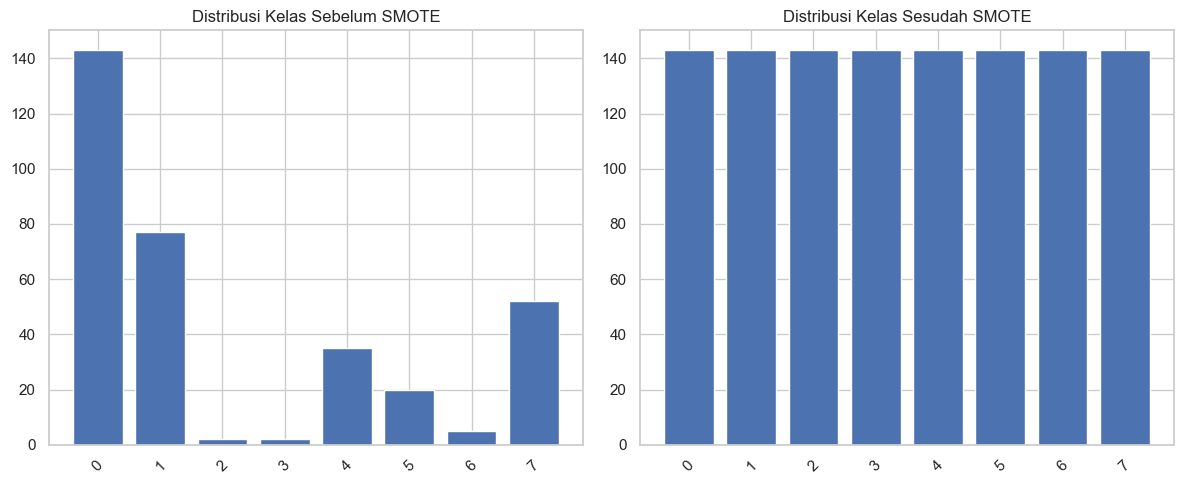

In [93]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Sebelum SMOTE
axes[0].bar(Counter(y).keys(), Counter(y).values())
axes[0].set_title("Distribusi Kelas Sebelum SMOTE")
axes[0].tick_params(axis='x', rotation=45)

# Sesudah SMOTE
axes[1].bar(Counter(y_sm).keys(), Counter(y_sm).values())
axes[1].set_title("Distribusi Kelas Sesudah SMOTE")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


Klasifiksai menggunakan Naive Bayes setalah SMOTE

In [94]:
# Split data SMOTE
X_train, X_test, y_train, y_test = train_test_split(
    X_sm, y_sm, test_size=0.2, random_state=42, stratify=y_sm
)

# Inisialisasi Naive Bayes dengan smoothing
nb = GaussianNB(var_smoothing=1e-8)

# Latih model
nb.fit(X_train, y_train)

# Prediksi data uji
y_pred = nb.predict(X_test)

# Evaluasi hasil
print("Akurasi Naive Bayes (SMOTE):", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Akurasi Naive Bayes (SMOTE): 0.8646288209606987

Classification Report:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89        28
           1       1.00      0.50      0.67        28
           2       1.00      1.00      1.00        29
           3       1.00      1.00      1.00        29
           4       0.81      0.86      0.83        29
           5       1.00      0.61      0.76        28
           6       1.00      1.00      1.00        29
           7       0.60      0.93      0.73        29

    accuracy                           0.86       229
   macro avg       0.90      0.86      0.86       229
weighted avg       0.90      0.86      0.86       229


Confusion Matrix:
 [[28  0  0  0  0  0  0  0]
 [ 5 14  0  0  6  0  0  3]
 [ 0  0 29  0  0  0  0  0]
 [ 0  0  0 29  0  0  0  0]
 [ 0  0  0  0 25  0  0  4]
 [ 0  0  0  0  0 17  0 11]
 [ 0  0  0  0  0  0 29  0]
 [ 2  0  0  0  0  0  0 27]]


Klasifikasi menggunakan Random Forest setelah SMOTE

In [95]:
# Split data SMOTE
X_train, X_test, y_train, y_test = train_test_split(
    X_sm, y_sm, test_size=0.2, random_state=42, stratify=y_sm
)

# Inisialisasi Random Forest
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)

# Latih model
rf.fit(X_train, y_train)

# Prediksi data uji
y_pred = rf.predict(X_test)

# Evaluasi hasil
print("Akurasi Random Forest (SMOTE):", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Akurasi Random Forest (SMOTE): 0.9519650655021834

Classification Report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.93        28
           1       0.89      0.86      0.87        28
           2       1.00      1.00      1.00        29
           3       1.00      1.00      1.00        29
           4       0.89      0.86      0.88        29
           5       1.00      0.96      0.98        28
           6       1.00      1.00      1.00        29
           7       0.96      0.93      0.95        29

    accuracy                           0.95       229
   macro avg       0.95      0.95      0.95       229
weighted avg       0.95      0.95      0.95       229


Confusion Matrix:
 [[28  0  0  0  0  0  0  0]
 [ 1 24  0  0  3  0  0  0]
 [ 0  0 29  0  0  0  0  0]
 [ 0  0  0 29  0  0  0  0]
 [ 1  3  0  0 25  0  0  0]
 [ 0  0  0  0  0 27  0  1]
 [ 0  0  0  0  0  0 29  0]
 [ 2  0  0  0  0  0  0 27]]


Klasifikasi menggunakan BaggingClassifier setelah SMOTE

In [96]:
# Bagging dengan Naive Bayes
bag_nb = BaggingClassifier(
    estimator=GaussianNB(var_smoothing=1e-8),
    n_estimators=100,
    random_state=42
)

bag_nb.fit(X_train, y_train)
y_pred = bag_nb.predict(X_test)

print("Akurasi Bagging (Naive Bayes, SMOTE):", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Akurasi Bagging (Naive Bayes, SMOTE): 0.8733624454148472

Classification Report:
               precision    recall  f1-score   support

           0       0.82      1.00      0.90        28
           1       0.82      0.64      0.72        28
           2       1.00      1.00      1.00        29
           3       1.00      1.00      1.00        29
           4       0.85      0.76      0.80        29
           5       1.00      0.64      0.78        28
           6       1.00      1.00      1.00        29
           7       0.64      0.93      0.76        29

    accuracy                           0.87       229
   macro avg       0.89      0.87      0.87       229
weighted avg       0.89      0.87      0.87       229


Confusion Matrix:
 [[28  0  0  0  0  0  0  0]
 [ 4 18  0  0  4  0  0  2]
 [ 0  0 29  0  0  0  0  0]
 [ 0  0  0 29  0  0  0  0]
 [ 0  4  0  0 22  0  0  3]
 [ 0  0  0  0  0 18  0 10]
 [ 0  0  0  0  0  0 29  0]
 [ 2  0  0  0  0  0  0 27]]


In [97]:
# Bagging dengan Decision Tree
bag_dt = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=100,
    random_state=42
)

bag_dt.fit(X_train, y_train)
y_pred = bag_dt.predict(X_test)

print("Akurasi Bagging (Decision Tree, SMOTE):", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Akurasi Bagging (Decision Tree, SMOTE): 0.9432314410480349

Classification Report:
               precision    recall  f1-score   support

           0       0.85      1.00      0.92        28
           1       0.92      0.82      0.87        28
           2       1.00      1.00      1.00        29
           3       1.00      1.00      1.00        29
           4       0.86      0.86      0.86        29
           5       0.96      0.96      0.96        28
           6       1.00      1.00      1.00        29
           7       0.96      0.90      0.93        29

    accuracy                           0.94       229
   macro avg       0.94      0.94      0.94       229
weighted avg       0.95      0.94      0.94       229


Confusion Matrix:
 [[28  0  0  0  0  0  0  0]
 [ 1 23  0  0  4  0  0  0]
 [ 0  0 29  0  0  0  0  0]
 [ 0  0  0 29  0  0  0  0]
 [ 2  2  0  0 25  0  0  0]
 [ 0  0  0  0  0 27  0  1]
 [ 0  0  0  0  0  0 29  0]
 [ 2  0  0  0  0  1  0 26]]


Penyeimbangan dan Klasifikasi ADASYN

In [98]:
from imblearn.over_sampling import ADASYN
from collections import Counter

naive_bayes = df
X = naive_bayes.drop(columns=["localization_class", "protein_name"])  # fitur numerik
y = naive_bayes["localization_class"]

print("\nDistribusi kelas awal:")
print(sorted(Counter(y).items()))

class_counts = [count for _, count in Counter(y).items()]
temp = sorted(class_counts)

nt, ns = X, y  # salin awal
print(f"\nSorted counts untuk iterasi: {temp}")

for i in range(0, min(7, len(temp))):
    n = max(1, temp[i] - 1)  # n_neighbors tidak boleh < 1
    # print(f"\nIterasi {i+1}: menggunakan k_neighbors={n}")

    try:
        sampler = ADASYN(n_neighbors=n, sampling_strategy='minority', random_state=42)
        nt, ns = sampler.fit_resample(nt, ns)
        # print(f"Hasil iterasi {i+1}: {sorted(Counter(ns).items())}")
    except Exception as e:
        print(f"Error pada iterasi {i+1}: {e}")
        break

print(f"\nDistribusi kelas setelah ADASYN:")
print(f"{sorted(Counter(ns).items())}")

print(f"\nTotal samples sebelum: {len(y)}")
print(f"Total samples setelah: {len(ns)}")
print(f"Data yang ditambahkan: {len(ns) - len(y)}")



Distribusi kelas awal:
[('cp', 143), ('im', 77), ('imL', 2), ('imS', 2), ('imU', 35), ('om', 20), ('omL', 5), ('pp', 52)]

Sorted counts untuk iterasi: [2, 2, 5, 20, 35, 52, 77, 143]

Distribusi kelas setelah ADASYN:
[('cp', 143), ('im', 142), ('imL', 143), ('imS', 143), ('imU', 144), ('om', 143), ('omL', 143), ('pp', 144)]

Total samples sebelum: 336
Total samples setelah: 1145
Data yang ditambahkan: 809


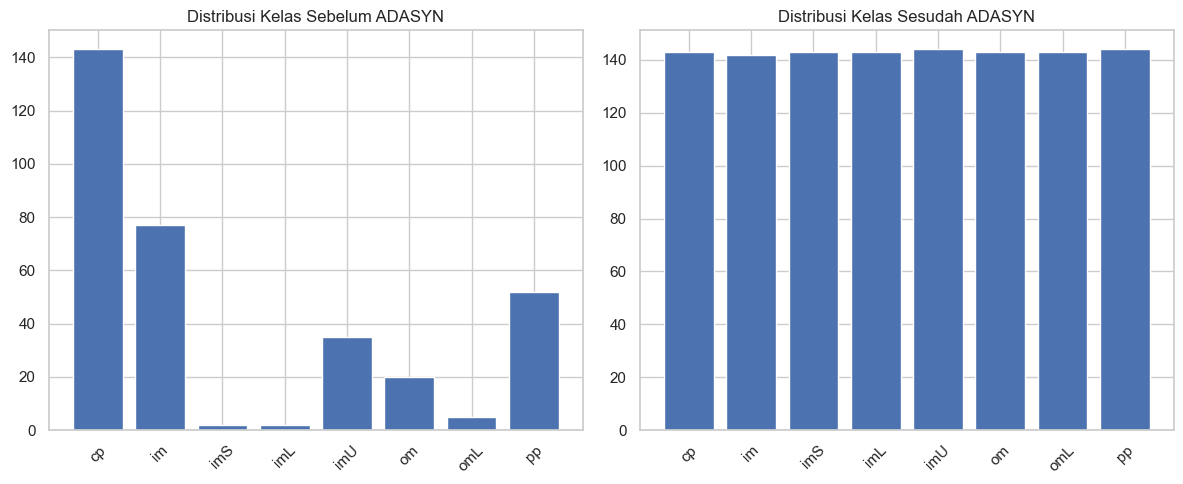

In [99]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Sebelum ADASYN
axes[0].bar(Counter(y).keys(), Counter(y).values())
axes[0].set_title("Distribusi Kelas Sebelum ADASYN")
axes[0].tick_params(axis='x', rotation=45)

# Sesudah ADASYN
axes[1].bar(Counter(ns).keys(), Counter(ns).values())
axes[1].set_title("Distribusi Kelas Sesudah ADASYN")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


Klasifikasi menggunakan Naive Bayes setelah ADASYN

In [100]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Split data ADASYN
X_train, X_test, y_train, y_test = train_test_split(
    nt, ns, test_size=0.3, random_state=42, stratify=ns
)

# Inisialisasi Naive Bayes
nb = GaussianNB()

# Latih model
nb.fit(X_train, y_train)

# Prediksi
y_pred = nb.predict(X_test)

# Evaluasi
print("Akurasi Naive Bayes (ADASYN):", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Akurasi Naive Bayes (ADASYN): 0.9767441860465116

Classification Report:
               precision    recall  f1-score   support

          cp       0.96      1.00      0.98        43
          im       0.91      0.98      0.94        43
         imL       1.00      1.00      1.00        43
         imS       1.00      1.00      1.00        43
         imU       0.97      0.91      0.94        43
          om       1.00      0.98      0.99        43
         omL       1.00      1.00      1.00        43
          pp       0.98      0.95      0.96        43

    accuracy                           0.98       344
   macro avg       0.98      0.98      0.98       344
weighted avg       0.98      0.98      0.98       344


Confusion Matrix:
 [[43  0  0  0  0  0  0  0]
 [ 0 42  0  0  1  0  0  0]
 [ 0  0 43  0  0  0  0  0]
 [ 0  0  0 43  0  0  0  0]
 [ 0  4  0  0 39  0  0  0]
 [ 0  0  0  0  0 42  0  1]
 [ 0  0  0  0  0  0 43  0]
 [ 2  0  0  0  0  0  0 41]]


Klasifikasi menggunakan Random Forest setalh ADASYN

In [101]:
from sklearn.ensemble import RandomForestClassifier

# Split data ADASYN (sudah sama seperti sebelumnya, jadi bisa pakai ulang)
X_train, X_test, y_train, y_test = train_test_split(
    nt, ns, test_size=0.2, random_state=42, stratify=ns
)

# Inisialisasi Random Forest
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)

# Latih model
rf.fit(X_train, y_train)

# Prediksi
y_pred = rf.predict(X_test)

# Evaluasi
print("Akurasi Random Forest (ADASYN):", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Akurasi Random Forest (ADASYN): 1.0

Classification Report:
               precision    recall  f1-score   support

          cp       1.00      1.00      1.00        29
          im       1.00      1.00      1.00        28
         imL       1.00      1.00      1.00        28
         imS       1.00      1.00      1.00        29
         imU       1.00      1.00      1.00        29
          om       1.00      1.00      1.00        29
         omL       1.00      1.00      1.00        28
          pp       1.00      1.00      1.00        29

    accuracy                           1.00       229
   macro avg       1.00      1.00      1.00       229
weighted avg       1.00      1.00      1.00       229


Confusion Matrix:
 [[29  0  0  0  0  0  0  0]
 [ 0 28  0  0  0  0  0  0]
 [ 0  0 28  0  0  0  0  0]
 [ 0  0  0 29  0  0  0  0]
 [ 0  0  0  0 29  0  0  0]
 [ 0  0  0  0  0 29  0  0]
 [ 0  0  0  0  0  0 28  0]
 [ 0  0  0  0  0  0  0 29]]


Klasifikasi menggunakan BaggingClassifier setelah ADASYN

In [102]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Bagging dengan Naive Bayes
bag_nb = BaggingClassifier(
    estimator=GaussianNB(),
    n_estimators=100,
    random_state=42
)

bag_nb.fit(X_train, y_train)
y_pred = bag_nb.predict(X_test)

print("Akurasi Bagging (Naive Bayes, ADASYN):", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Akurasi Bagging (Naive Bayes, ADASYN): 0.9781659388646288

Classification Report:
               precision    recall  f1-score   support

          cp       0.94      1.00      0.97        29
          im       1.00      1.00      1.00        28
         imL       1.00      1.00      1.00        28
         imS       1.00      1.00      1.00        29
         imU       1.00      0.93      0.96        29
          om       1.00      0.97      0.98        29
         omL       1.00      1.00      1.00        28
          pp       0.90      0.93      0.92        29

    accuracy                           0.98       229
   macro avg       0.98      0.98      0.98       229
weighted avg       0.98      0.98      0.98       229


Confusion Matrix:
 [[29  0  0  0  0  0  0  0]
 [ 0 28  0  0  0  0  0  0]
 [ 0  0 28  0  0  0  0  0]
 [ 0  0  0 29  0  0  0  0]
 [ 0  0  0  0 27  0  0  2]
 [ 0  0  0  0  0 28  0  1]
 [ 0  0  0  0  0  0 28  0]
 [ 2  0  0  0  0  0  0 27]]


In [103]:
# Bagging dengan Decision Tree
bag_dt = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=100,
    random_state=42
)

bag_dt.fit(X_train, y_train)
y_pred = bag_dt.predict(X_test)

print("Akurasi Bagging (Decision Tree, ADASYN):", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Akurasi Bagging (Decision Tree, ADASYN): 0.9956331877729258

Classification Report:
               precision    recall  f1-score   support

          cp       0.97      1.00      0.98        29
          im       1.00      0.96      0.98        28
         imL       1.00      1.00      1.00        28
         imS       1.00      1.00      1.00        29
         imU       1.00      1.00      1.00        29
          om       1.00      1.00      1.00        29
         omL       1.00      1.00      1.00        28
          pp       1.00      1.00      1.00        29

    accuracy                           1.00       229
   macro avg       1.00      1.00      1.00       229
weighted avg       1.00      1.00      1.00       229


Confusion Matrix:
 [[29  0  0  0  0  0  0  0]
 [ 1 27  0  0  0  0  0  0]
 [ 0  0 28  0  0  0  0  0]
 [ 0  0  0 29  0  0  0  0]
 [ 0  0  0  0 29  0  0  0]
 [ 0  0  0  0  0 29  0  0]
 [ 0  0  0  0  0  0 28  0]
 [ 0  0  0  0  0  0  0 29]]


## Perbandingan Hasil

Tabel berikut membandingkan performa model Naive Bayes, Random Forest, dan Bagging pada tiga kondisi data:
- Asli (belum diseimbangkan)
- SMOTE (Synthetic Minority Oversampling Technique)
- ADASYN (Adaptive Synthetic Sampling)

Metrik yang digunakan:
- Accuracy
- Macro F1-score

In [106]:
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE, ADASYN
from collections import Counter
import pandas as pd

# Siapkan data X dan y asli dari DataFrame Anda
X = df.drop(columns=["id", "protein_name", "localization_class"]).values
y_labels = df["localization_class"]
y = y_labels.astype("category").cat.codes.values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# SMOTE pada data training
smote = SMOTE(k_neighbors=1, random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# ADASYN pada data training
# Menggunakan loop untuk mengatasi error k_neighbors seperti di kode Anda
X_train_ad, y_train_ad = X_train, y_train
class_counts = sorted([count for _, count in Counter(y_train).items()])
for i in range(len(class_counts) - 1):
    n = max(1, class_counts[i] - 1)
    try:
        adasyn = ADASYN(n_neighbors=n, sampling_strategy='minority', random_state=42)
        X_train_ad, y_train_ad = adasyn.fit_resample(X_train_ad, y_train_ad)
    except Exception:
        break

results = []

def evaluate_model(name, model, X_tr, y_tr, dataset_label):
    # Latih model pada data training (asli atau oversampled)
    model.fit(X_tr, y_tr)
    # Uji model SELALU pada data test asli yang belum diubah
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="macro", zero_division=0)
    results.append({
        "Model": name,
        "Dataset": dataset_label,
        "Accuracy": round(acc, 4),
        "Macro F1": round(f1, 4)
    })

# Model yang akan dievaluasi
models = {
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Bagging (NB)": BaggingClassifier(estimator=GaussianNB(), n_estimators=100, random_state=42),
    "Bagging (DT)": BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42), n_estimators=100, random_state=42)
}

# Data training untuk setiap skenario
train_data = {
    "Asli": (X_train, y_train),
    "SMOTE": (X_train_sm, y_train_sm),
    "ADASYN": (X_train_ad, y_train_ad)
}

# Lakukan evaluasi untuk setiap model dan setiap jenis data training
for dataset_label, (X_tr, y_tr) in train_data.items():
    for model_name, model in models.items():
        evaluate_model(model_name, model, X_tr, y_tr, dataset_label)

# Tampilkan hasil dalam bentuk tabel pivot
df_results = pd.DataFrame(results)
df_results_pivot = df_results.pivot(index="Model", columns="Dataset", values=["Accuracy", "Macro F1"])
print("Hasil Perbandingan :")
display(df_results_pivot)

C:\Users\user\AppData\Roaming\Python\Python311\site-packages\sklearn\naive_bayes.py:509: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\sklearn\naive_bayes.py:509: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\sklearn\naive_bayes.py:509: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\sklearn\naive_bayes.py:509: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\sklearn\naive_bayes.py:509: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\sklearn\naive_bayes.py:509: RuntimeWarning: 

Hasil Perbandingan :


Accuracy                 Macro F1                
Dataset         ADASYN    Asli   SMOTE   ADASYN    Asli   SMOTE
Model                                                          
Bagging (DT)    0.8382  0.8382  0.7941   0.7255  0.8416  0.7672
Bagging (NB)    0.9118  0.9118  0.8382   0.9108  0.9108  0.7990
Naive Bayes     0.7941  0.7941  0.7941   0.6637  0.6637  0.6629
Random Forest   0.8824  0.8676  0.8824   0.8846  0.8732  0.8821

Visual Plot Data

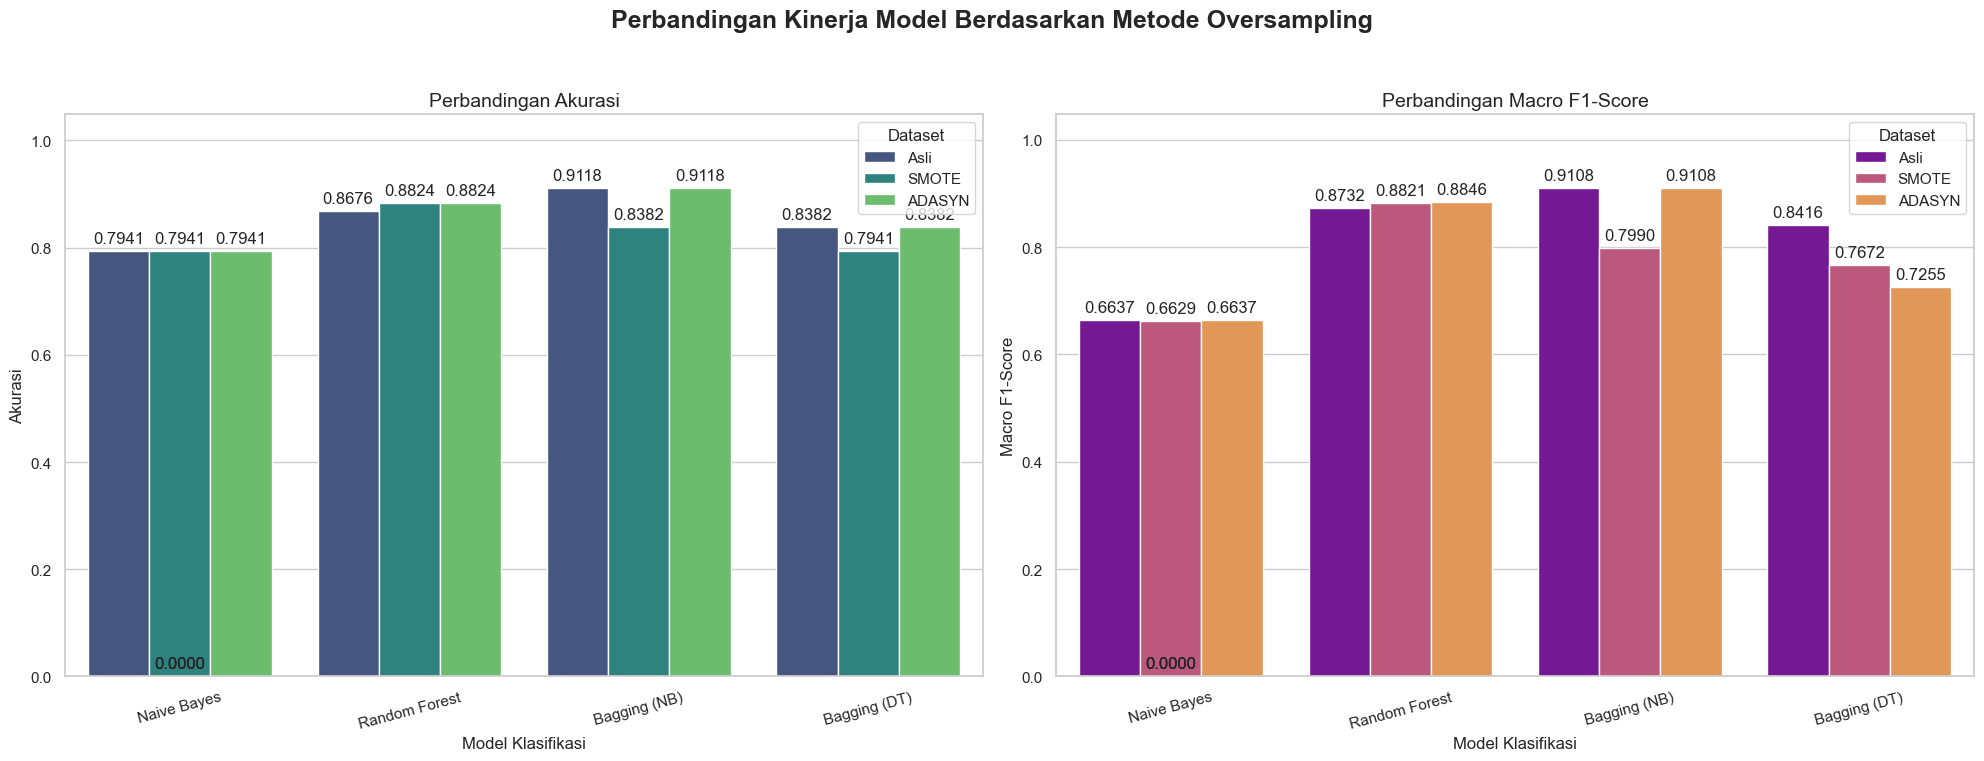

In [105]:
# Import library yang dibutuhkan untuk visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(20, 8)) # 1 baris, 2 kolom plot
fig.suptitle('Perbandingan Kinerja Model Berdasarkan Metode Oversampling', fontsize=18, fontweight='bold')

# Accuracy
ax1 = sns.barplot(
    data=df_results,
    x='Model',
    y='Accuracy',
    hue='Dataset', # Grupkan berdasarkan jenis dataset
    palette='viridis',
    ax=axes[0]
)
ax1.set_title('Perbandingan Akurasi', fontsize=14)
ax1.set_xlabel('Model Klasifikasi', fontsize=12)
ax1.set_ylabel('Akurasi', fontsize=12)
ax1.set_ylim(0, max(df_results['Accuracy']) * 1.15) # Atur batas sumbu y
ax1.tick_params(axis='x', rotation=15)

for p in ax1.patches:
    ax1.annotate(format(p.get_height(), '.4f'),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 9),
                   textcoords = 'offset points')

# F1 Score
ax2 = sns.barplot(
    data=df_results,
    x='Model',
    y='Macro F1',
    hue='Dataset',
    palette='plasma',
    ax=axes[1]
)
ax2.set_title('Perbandingan Macro F1-Score', fontsize=14)
ax2.set_xlabel('Model Klasifikasi', fontsize=12)
ax2.set_ylabel('Macro F1-Score', fontsize=12)
ax2.set_ylim(0, max(df_results['Macro F1']) * 1.15) # Atur batas sumbu y
ax2.tick_params(axis='x', rotation=15)

# Tambahkan label nilai di atas setiap bar
for p in ax2.patches:
    ax2.annotate(format(p.get_height(), '.4f'),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 9),
                   textcoords = 'offset points')

# Menyesuaikan layout dan menampilkan plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()